## Goals of this script: ## 

• Plot drive cycle (velocity over time) by route  

• Obtain total distance traveled along route, accounting for elevation change\

• Plot route on OpenStreetMap

--> Estimate the energy requirement for traveling along the route
    • the metadata will come in different csv's for each minibus, so adapt Fili's code to loop through the files and read them all in, and then for loop thru each for calculations.
---------------------------------------------------------------------------------------------------------

Current concerns:


**Slope calcluation** a bit sussed out about this one. 

**Acceleration calculations** give all very similar values when calculated from vector (around 1). And never negative  - what's the best way to convert to negative? (note, even when manually adjusted i.e. accounting for regen brake, energy exp calcs still too high)

**Energy Expenditure calculation** is giving way too high of a number. I think this has to do with some physical parameter. I thought maybe it had to do with sus slope calculation, but setting all slopes to 0 only decreases final sum by 500 out of tens of thousands of kWh. That is still quite a bit and could indicate that the slope calculation is wrong, but is not the main problem here. Am using V2GO output as part of the sanity check. 

In [171]:
import pandas as pd
import os
import numpy as np
import geopy.distance
import datetime
import geopandas
import matplotlib as matplotlib
import matplotlib.pyplot as plt

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

import folium

## Main

Processing journey: KMDI - STB
Total energy consumption for the route: 98987.01979224048 kWh
That's too high bro!!!


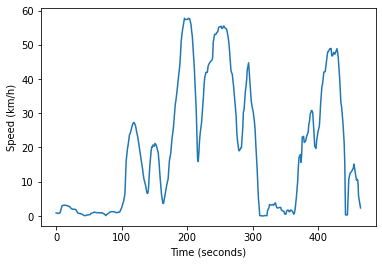

Processing journey: SW - STB
Total energy consumption for the route: 6830960.077076887 kWh
That's too high bro!!!


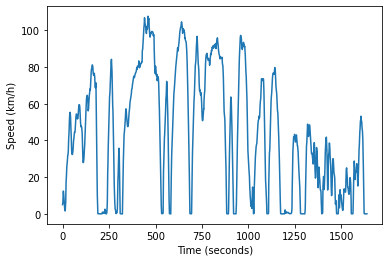

Processing journey: STB - KMDI
Total energy consumption for the route: 148064.40622542254 kWh
That's too high bro!!!


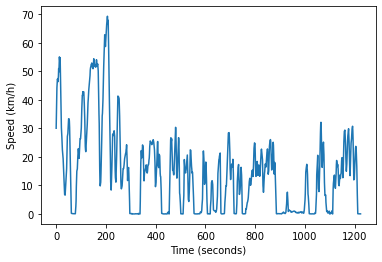

Processing journey: STB - SW
Total energy consumption for the route: 5679384.563096405 kWh
That's too high bro!!!


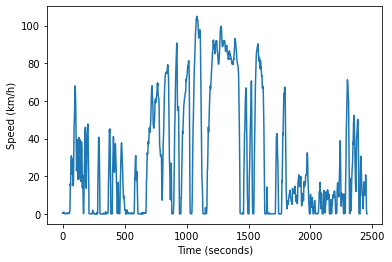

In [195]:
files = [x for x in os.listdir('.') if x.endswith('.CSV')] #Input files
raw_journeys = {} # Dictionary to hold raw journey data
processed_journeys = {} # Dictionary to hold processed data


for filename in files:
    route = os.path.splitext(filename)[0]
    raw_journeys[route] = read_file(filename) #Read files

for key,val in raw_journeys.items():
    print("Processing journey:", key)
    journey = val
    
    getDistSlope(journey)

    # Instantiate vehicle object
    minibus = Vehicle()
    # Create drivecycle object with trip data
    drvcycle = Drivecycle(journey)
    
    # Compute energy expenditure (with and without regenerative braking)
    enJ = minibus.getEnergyExpenditure(drvcycle)
    enJnoRG = minibus.getEnergyExpenditure(drvcycle, regbrake = False) 
    journey['PowerW'] = enJnoRG
    journey['PowerW_RG'] = enJ
    
    # Compute SoC at each timestamp
    journey['SoC_RG'] = np.array(enJ)/3.6e6/minibus.capacity # decrease in SoC

    # debug
    print("Total energy consumption for the route:", journey.PowerW.sum()/1e3, "kWh")
    if journey.PowerW_RG.sum()/1e3 > 50:
        print("That's too high bro!!!")
    else:
        print("Let's get some EVs up in here")
    fig = plt.figure()
    plt.plot(journey['RelTime'], journey['Speed'])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Speed (km/h)")
    plt.show()
    
    processed_journeys[key] = journey

In [188]:
debug_df = processed_journeys['KMDI - STB']
debug_df['RelTime']

AttributeError: 'Series' object has no attribute 'time'

In [190]:
''' 
Takes in name of csv file with vehicle journey data
Returns augmented dataframe ready for analysis

TODO: Take out acceleration sanity check when no longer needed
'''
def read_file(filename):
    journey = pd.read_csv(filename)
   
    # Join date and time columns into one column, and drop individual columns
    journey['DateTime'] = pd.to_datetime(journey['Date'] + journey['Time'], format = '%m/%d/%Y%H:%M:%S')
    
    # Calculate acceleration from x,y,z-axis accelerations
    journey['Acceleration'] = np.sqrt(journey['X-Axis Acceleration']**2 + journey['Y-Axis Acceleration']**2 + journey['Z-Axis Acceleration']**2)
    

    # Calculate time elapsed between each timestamp
    journey['DeltaT'] = journey['DateTime'] - journey['DateTime'].shift(1) 
    journey.DeltaT = journey['DeltaT'] / np.timedelta64(1, 's') # Convert from timedelta to int
    
    # Sanity check on acceleration using dV/dT

    journey['DeltaV'] = journey['Speed'] - journey['Speed'].shift(1) 
    journey['Acceleration_2'] = journey['DeltaV']/journey['DeltaT']

    
    # Relative time from start of journey, used for plotting drive cycle
    journey["RelTime"] = journey["DateTime"] - journey["DateTime"].min() 
    journey.RelTime = journey['RelTime'] / np.timedelta64(1, 's') # Convert from timedelta to int
        
    # Elevation change between each recording
    journey['ElevChange'] = journey['Altitude'] - journey["Altitude"].shift(1) # Ma y not be needed if don't use haversine function 
   
    # Joins Lat/Lon Coords into one column, useful for getDist function
    journey['Coordinates'] = list(zip(journey.Latitude, journey.Longitude)) 

    return journey


In [103]:
''' 
Inputs: dataframe with vehicle journey data

Calculates distance between each successive pair of lat/lon coordinates
(accounts for elevation difference)

Calculates slope angle faced by vehicle at each timestamp

'''
def getDistSlope(journey):
    Distance = np.zeros(len(journey))
    Slope = np.zeros(len(journey))
    Slope_tan = np.zeros(len(journey))
    l_route = journey.shape[0]

    for i in range(1,l_route):
        elev_change = journey.Altitude.iloc[i]-journey.Altitude.iloc[i-1]
        dist_lateral = geopy.distance.geodesic(journey.Coordinates.iloc[i-1],  # Lateral distance in meters - dist between two lat/lon coord pairs
                                       journey.Coordinates.iloc[i]).m
        dist_3d = np.sqrt(dist_lateral**2 + elev_change**2)  # 3d dist -- accounting for elevation
        Distance[i] = dist_3d/1e3 # convert to km
        if Distance[i] != 0:
            Slope[i] = np.arccos(dist_lateral/dist_3d) # Would rather use arcsin since that uses 1 measured value instead of 2 calculated values, but that doesn't work
        
    journey['Distance_3D_km'] = list(Distance)
    journey['slope_rad'] = list(Slope) 

## Energy Requirements Analysis 
To-Do: implement vehicle parameters, get estimated energy consumption for a route. Get SoC along route

In [104]:
# Functions that calculate four different types of forces acting on the vehicle, used in calculating total road load 
# based on functions shown here https://x-engineer.org/ev-design-energy-consumption/\

# Inertial Force
def getInertialForce(mass, accel):
    return mass * accel

# Road load (friction)
def getRoadFriction(mass, c_rr, slope, grav = 9.81): #c_rr is coeff of rolling resistance
    return mass * grav * c_rr * np.cos(slope)

# Aerodynamic Drag Force
def getAerodynamicDrag(c_d, A, vel, rho = 1.204,): # rho is air density 20C, c_d is air drag coeff
    return 0.5 * rho * c_d * A * vel**2

# Road Slope Force
def getRoadSlopeDrag(mass, slope, grav = 9.81):
    return mass * grav * np.sin(slope)

In [74]:
class Vehicle:
    """
    Inputs: Physical parameters of vehicle for modeling energy consumption
    
    mass - vehicle mass (kg)
    cd - coefficient of drag
    crr - coefficient of rolling resistance
    A - vehicle frontal area (m^2)
    eff - vehicle propulsion efficiency
    rgbeff - regenerative braking energy recuperation efficiency 
    cap - vehicle battery cap (kWh)
    p0 - constant power intake (W)
    """
    
    def __init__(self, mass = 2900, 
                 cd = 0.5, crr = 0.01, A = 4,
                 eff = 0.8, rgbeff = 0.5, cap = 100, p0 = 100):
        self.imei = imei # data logger identifier
        self.reg_n = 'n/a' # registration number
        self.frames = {} # where routes data will be stored
        self.journey_info = [] # journey_dT objects linekd here
        self.v2g_stops = None 
        
        # Vehicle physical parameters
        self.mass = mass # kg
        self.load = 0.0 #kg
        self.crr = crr # coefficient of rolling resistance
        self.cd = cd  # air drag coefficient
        self.A = 4 # m^2, Approximation of vehicle frontal area 
        self.eff = eff
        self.rgbeff = rgbeff 
        self.capacity = cap 
        self.battery = cap
        self.p0 = p0 # constant power loss in W (to run the vehicle besides driving)
        
    def getEnergyExpenditure(self,cycle,regbrake = True):
        # computes energy expenditure from a Drivecycle object
        # dt default 1 second
        
        v = cycle.velocity # m/s
        s = cycle.slope # rad
        a = cycle.acceleration # m/s^2
        dt = cycle.dt # s
        
        if regbrake == True:
            RGBeff = self.rgbeff
        else:
            RGBeff = 0
                        
        Fr = [] # Drag force: Inertia + Friction + Aero Drag
        Er = [] # Energy dissipated from drag
        for slope,vel,acc,delta_time in zip(s,v,a,dt):
            force = getInertialForce(self.mass, acc) + getRoadFriction(self.mass,self.crr, slope) + getAerodynamicDrag(self.cd, self.A, vel**2)
            Fr.append(force)
            Er.append(force*vel*delta_time)
        
            
        Fs = [] # Slope component (defined as drag) - slope is broken out from rest of total road load, in case EV brakes on downhill 
        Es = [] # Energy associated to slope
        for slope,vel,delta_time in zip(s,v,dt):
            force = getRoadSlopeDrag(self.mass, slope)
            Fs.append(force)
            Es.append(force*vel*delta_time)
            
        # Drivetrain energy (wheel side): engine/brake force counteracts drag forces
        Em = [x+y for x,y in zip(Es,Er)] # from battery if positive, to battery if negative (RGbrake)
        
        # takes into account efficiency of charge/discharge etc...
        Em_eff = [0.0]*len(Em) # initialize vector of 0's having length of drivetrain eenergy vector
        for i in range(len(Em)):
            if Em[i] > 0:
                Em_eff[i] = Em[i]/self.eff
            elif Em[i] < 0:
                Em_eff[i]= Em[i]*RGBeff 
        
         
        # adds constant loss p0 (0.1 kW)
        for i in range(len(Em_eff)):
            if v[i] > 2.0: # [km/h] to make sure that the vehicle is not parked (and engine maybe turned off)
                Em_eff[i] += self.p0

        return Em_eff

In [ ]:
  def getEnergyExpenditure(self,cycle,regbrake = True):
        # computes energy expenditure from a Drivecycle object
        # dt default 1 second
        
        v = cycle.velocity # m/s
        s = cycle.slope # rad
        a = cycle.acceleration # m/s^2
        dt = cycle.dt # s
        
        if regbrake == True:
            RGBeff = self.rgbeff
        else:
            RGBeff = 0
        for slope, vel in zip(s,v)                
            e_kwh = getRoadSlopeDrag() + getAerodynamicDrag
        return Em_eff

In [145]:
class Drivecycle: 
    """
    Inputs: dataframe with journey info
    """
    def __init__(self, journey_df): 
        self.displacement = journey_df.Distance_3D_km # m
        self.velocity = journey_df.Speed/3.6 # convert km/h to m/s
        self.acceleration = journey_df.Acceleration # m/s^2
        self.slope = journey_df.slope_rad
        self.time = journey_df.RelTime.max() # Total Time Elapsed
        self.dt = journey_df.DeltaT
        

In [ ]:
# Plotting route on Folium
map1 = folium.Map(
    location=[df["Latitude"][1], df["Longitude"][1]],
    tiles='cartodbpositron',
    zoom_start=12,
)
df.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]]).add_to(map1), axis=1)
map1

## Extra processing if needed, to use in the EV Fleet Simulator

In [244]:
newdf.to_csv("ev-fleet-sim-master/src/test_johan/_Inputs/Traces/Processed/test_johan.csv")

In [ ]:
newdf["Time"] = newdf["DateTime"]
newdf = newdf.drop(labels = ["DateTime"], axis = 1)

In [242]:
newdf["GPSID"] = newdf.index
newdf

,Latitude,Longitude,Altitude,Heading,X-Axis Acceleration,Y-Axis Acceleration,Z-Axis Acceleration,Velocity,Time,GPSID
0,-33.93113,18.85856,119.0,329.52,0.020,0.188,1.028,0.46,2022-03-10 15:08:51,0
1,-33.93113,18.85856,119.2,329.52,0.054,0.156,1.062,0.52,2022-03-10 15:08:53,1
2,-33.93113,18.85856,119.5,329.52,0.052,0.174,1.026,0.61,2022-03-10 15:08:55,2
3,-33.93113,18.85855,119.6,329.52,0.008,0.160,0.964,0.35,2022-03-10 15:08:56,3
4,-33.93113,18.85855,119.7,329.52,0.052,0.072,1.056,0.30,2022-03-10 15:08:57,4
...,...,...,...,...,...,...,...,...,...,...
613,-33.96375,18.84001,128.2,59.04,-0.076,0.160,0.952,7.07,2022-03-10 15:23:34,613
614,-33.96373,18.84003,128.1,35.08,0.028,0.142,1.024,0.26,2022-03-10 15:23:36,614
615,-33.96373,18.84003,127.9,35.08,0.104,0.116,0.960,0.09,2022-03-10 15:23:37,615
616,-33.96373,18.84003,128.8,35.08,0.112,0.156,0.994,0.07,2022-03-10 15:23:39,616
